# Create toy NEXT graphs

In [2]:
import random
import numpy as np
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data, Dataset

### Create the graph structure

##### Series of nodes joined by edges

In [3]:
def create_track_like_graph(num_nodes, min_edges_per_node, max_edges_per_node, max_neighbor_distance):
    '''
    Creates a graph with the desired num_nodes. It takes 
    - min_edges_per_node (which for the toy experiment will bealways 1), 
    - max_edges_per_node (at least has to be 1), and 
    - max_neighbor_distance (maximum distance an edge will exist between sucessive nodes)
    
    So, for max_neighbor_distance = 4, the node 0 can only be connected to nodes 1, 2, 3, 4 (and not with the rest)
    Also, if this happens at the end, we prevent that more nodes are created. So, in the same case, for a track with 10 nodes,
    the node 8 can only be connected to nodes 9 and 10 (11 and 12 are supressed)

    In general, if max_neighbor_dis > max_edges_per_node, one node will have the possibility to connect with far nodes and 
    have few connections, so this will create a ramified graph (not wanted for tracks). This happens when max_neighbor_dis < num_nodes,
    other way around the graph is forced to connect again only sucessive nodes (due to the condition to supress outside nodes).
    We will always need to fulfill that max_neighbor_dis < num_nodes.

    Taking max_neighbor_dis < max_edges_per_node makes the graph more track-like (connections cannot be further away). Also, the 
    max_neighbor_dis will always mark the maximum number of "forward" edges a node will have (in the algorithm, if we take a node
    and want to join it with N forward nodes, you cant have a max_edges_per_node of 5 but only can connect to the 2 following nodes!)

    The optim configuration is to have for tracks
    min_edges_per_node = 1
    max_edges_per_node ~ max_neighbor_distance = 2-3 
    '''
    # Create an empty graph
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(num_nodes))

    # Connect nodes to create a track-like structure
    for node in range(num_nodes - 1):
        num_edges = random.randint(min_edges_per_node, max_edges_per_node)
        # Connect the current node to a random set of next nodes
        
        # Create the next nodes from a sample of next node until next_node + maximum neighbour distance
        upper_node_lim = node + 1 + max_neighbor_distance
        max_node_neighbor = node + 2 if upper_node_lim > num_nodes else upper_node_lim

        max_num_edges = min(max_node_neighbor - node - 1, num_edges)
        next_nodes = random.sample(range(node + 1, max_node_neighbor), max_num_edges)
        for next_node in next_nodes:
            G.add_edge(node, next_node)

    return G


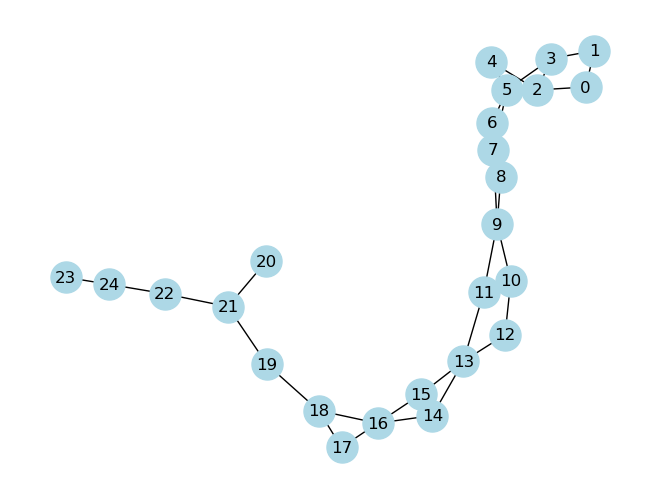

In [4]:
# Set parameters
num_nodes = round(random.gauss(20, 5)) #10  # Change this to the desired number of nodes
min_edges_per_node = 1  # Minimum edges per node, 1 always of course
max_edges_per_node = 2  # Maximum edges per node
max_neighbor_distance = 2 # Maximum node distance from a certain node

# Create the track-like graph
track_graph = create_track_like_graph(num_nodes, min_edges_per_node, max_edges_per_node, max_neighbor_distance)

edges = list(track_graph.edges)

#nodes serían las features según num_nodes, under construction :)
# Draw the graph (optional)
nx.draw(track_graph, with_labels=True, node_size=500, node_color='lightblue')

### Create the energy distribution

##### Higher energy depositions at the end of the track, uniform energy for the rest

In [5]:
#signal/bkg energy distribution creator

def en_dist(n, signal, disp = 1, rand = 10000):
    '''
    For a track with n nodes, it creates the energy distribution for signal and bkg.
    It is a mix of a uniform distribution among all the track, plus a gaussian distribution 
    centered in the extreme with certain dispersion (disp).
    If signal is True, the gaussian distribution is for both extremes.
    If sifnal is False, the gaussian distribution is for only one extreme (there is a 50% chance 
    for this extreme to be at the beggining or at the end)
    '''
    x = []
    extr = [0, n]
    #shuffle extremes so blob is not always at the beggining or at the end
    random.shuffle(extr)

    for i in range(rand):
        x.append(random.uniform(0, n))
        x.append(random.gauss(extr[0], disp))
        if signal:
            x.append(random.gauss(extr[1], disp))

    distr = np.histogram(x, n, range = (0,n), density = True)
    return distr, extr
    

(array([0.25331379, 0.1177646 , 0.04083128, 0.02817558, 0.02864184,
       0.02577766, 0.02584427, 0.0283088 , 0.02591088, 0.02557783,
       0.02664358, 0.02624392, 0.02591088, 0.02577766, 0.02884167,
       0.02784254, 0.02804236, 0.02744288, 0.02637714, 0.02504496,
       0.02524479, 0.02677679, 0.02697662, 0.02651036, 0.02617731]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.]))


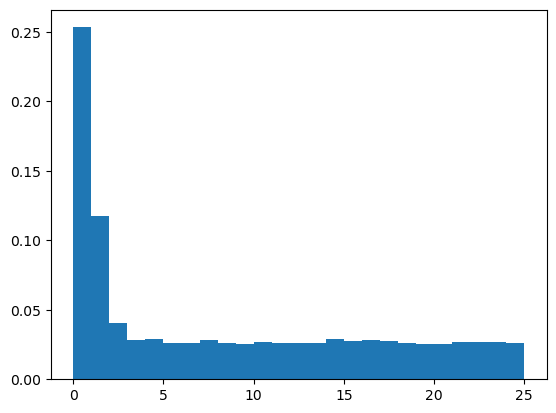

In [6]:
distr, _ = en_dist(num_nodes, False)
print(distr)
plt.bar(distr[1][:-1], distr[0], width=distr[1][1] - distr[1][0], align='edge')
plt.show()

### Label the nodes of the track

##### Study on how we should label (energy distribution extremes vs graph extremes)

In [7]:
def find_extrema_and_length(track_graph):
    """Find the extrema and the length of a track, given its dictionary of distances."""
    distance = dict(nx.all_pairs_dijkstra_path_length(track_graph))
    if len(distance) == 1:
        only_voxel = next(iter(distance))
        return (only_voxel, only_voxel, 0.)
    first, last, max_distance = None, None, 0
    for (voxel1, dist_from_voxel_1_to), (voxel2, _) in combinations(distance.items(), 2):
        d = dist_from_voxel_1_to[voxel2]
        if d > max_distance:
            first, last, max_distance = voxel1, voxel2, d
    return first, last, max_distance

In [8]:
#blob energy from graph extremes

def blob_ene_graph(track_graph, node_ener):
    '''
    Picks the energy from both graph extremes and the inmediate neighbors
    '''
    ext = find_extrema_and_length(track_graph)
    ext1_pos = list(track_graph.neighbors(ext[0])) + [ext[0]]
    ext2_pos = list(track_graph.neighbors(ext[1])) + [ext[1]]

    blob1_gr = sum([node_ener[i] for i in sorted(ext1_pos)])
    blob2_gr = sum([node_ener[i] for i in sorted(ext2_pos)])
    blob_gr = sorted([blob1_gr, blob2_gr], reverse = True)
    return blob_gr

#blob energy from original extremes
def blob_ene_original(nodes, n):
    '''
    Picks the energy from the n original extremes (from the energy distribution)
    '''
    blob_or = sorted([sum(nodes[:n]), sum(nodes[-n:])], reverse = True)
    return blob_or

Compute a toy experiment with 10000 events to see how both options work

In [213]:
nevents = 10000
sig_ratio = 0.3

# Mean and variance of the number of nodes for each track
mean_nnodes = 10
var_nnodes  = 2


min_edges_per_node = 1 
max_edges_per_node = 2  # Maximum edges per node
max_neighbor_distance = 2 # Maximum node distance from a certain node


blob_gr = []
blob_or = []
tot_ener = []
bin_class = []
for i in range(nevents):
    # Take the number of nodes
    num_nodes = round(random.gauss(mean_nnodes, var_nnodes))
    # Create the graph to obtain edges
    track_graph = create_track_like_graph(num_nodes, min_edges_per_node, max_edges_per_node, max_neighbor_distance)
    # Decide if the track will be signal or bkg (also constitutes the binary label)
    sig = True if random.uniform(0, 1) < sig_ratio else False
    bin_class.append(sig)
    # Create the energy distribution of the track
    ener, _ = en_dist(num_nodes, sig)
    nodes = ener[0]

    #find extrema for little study
    
    blob_gr.append(blob_ene_graph(track_graph, nodes))
    blob_or.append(blob_ene_original(list(nodes), 2))
    tot_ener.append()


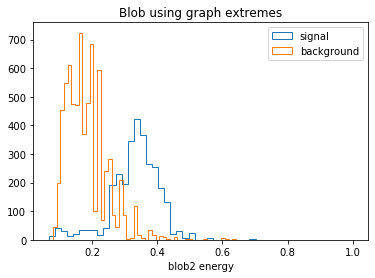

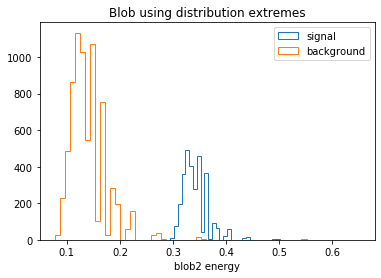

In [245]:
blob2_gr = np.array(blob_gr)[:, 1]
blob2_or = np.array(blob_or)[:, 1]

plt.hist(blob2_gr[np.array(bin_class)], 50, histtype = 'step', label = 'signal')
plt.hist(blob2_gr[~np.array(bin_class)], 50, histtype = 'step', label = 'background')
plt.legend()
plt.xlabel('blob2 energy')
plt.title('Blob using graph extremes')
plt.show()
plt.hist(blob2_or[np.array(bin_class)], 50, histtype = 'step', label = 'signal')
plt.hist(blob2_or[~np.array(bin_class)], 50, histtype = 'step', label = 'background')
plt.legend()
plt.xlabel('blob2 energy')
plt.title('Blob using distribution extremes')
plt.show()

After doing this, we see that clearly using the distribution extremes we get a clearer separation. What I think I'm gonna do is to use this extremes as blob label because in the data labelling I also use True information; the fact that then when voxelizing appear connections of nearby hits, it's only because the voxelization etc... but the labelling is based on the original True info we have!

After all, this decision is not taken based on the discrimination of the blobs, but on following the same thinking as for the real simulation data I'll be using

In [9]:
def label_orig_track(num_nodes, sig, extr, n_blob_nodes = 2):
    '''
    Put the label to the n_blob_nodes at the end of an extreme
    '''
    label = np.zeros(num_nodes, dtype = int)
    if sig:
        label[:n_blob_nodes]  = 1
        label[-n_blob_nodes:] = 1
    else:
        if extr[0] == 0:
            label[:n_blob_nodes] = 1
        else:
            label[-n_blob_nodes:] = 1
    return label
    

### Example of 1 event generation

In [10]:
def plot_graph_ener(track_graph, pos, nodes, label, cmap = plt.cm.cool, nsize = 200):
    nx.draw(track_graph, pos, node_color=list(nodes), cmap=cmap, node_size=nsize, with_labels=True)

    blob_nodes = [i for i, n in enumerate(label) if n != 0]
    nx.draw_networkx_nodes(track_graph, pos, nodelist=blob_nodes, node_color='none', edgecolors='black', node_size=nsize, linewidths=1.5)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(list(nodes)), vmax=max(list(nodes))))
    sm.set_array([])  # An empty array is required for ScalarMappable
    # Generate a legend with the marker and label
    legend_marker = plt.Line2D([], [], marker='o', color='white', markersize=10, markeredgewidth=1, markeredgecolor='black', label='Blob label')
    # Add the legend to the plot
    plt.legend(handles=[legend_marker])
    # Add a colorbar
    plt.colorbar(sm, label='Energy')
    plt.title('Node energy graph')
    plt.show()

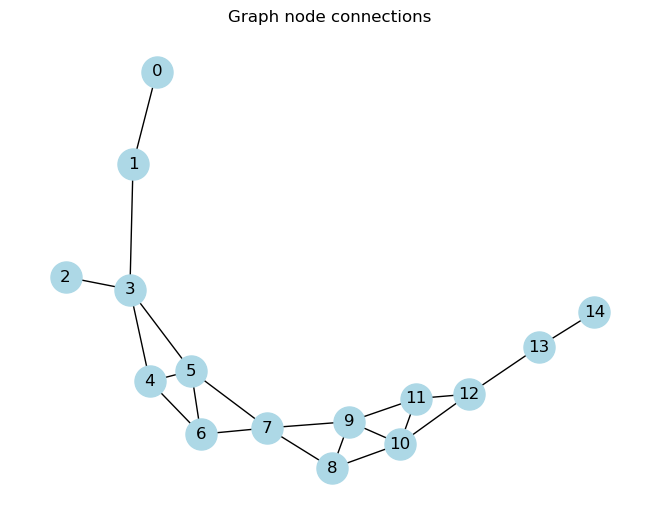

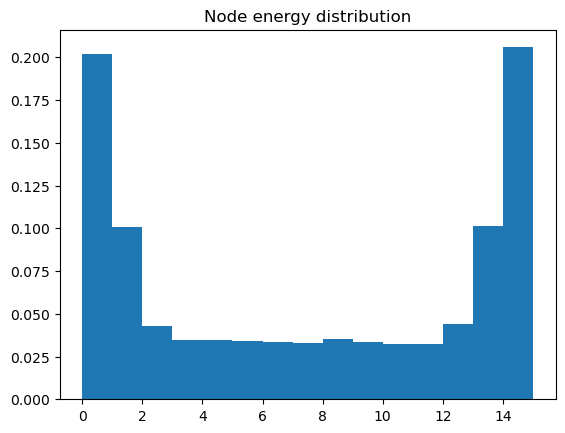

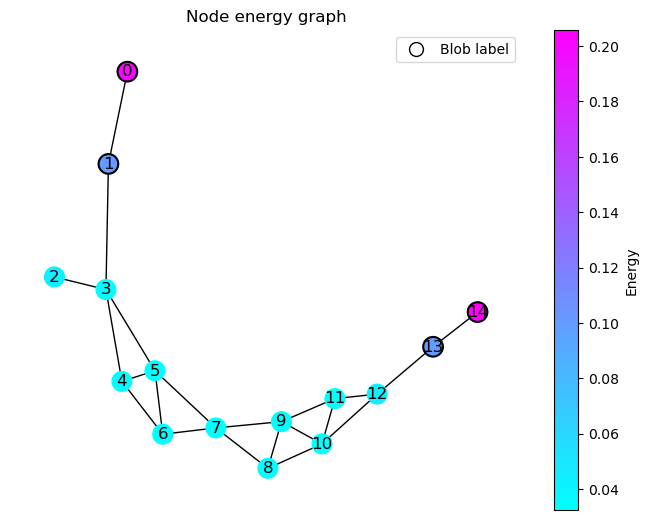

SIGNAL event

Edges list:   [(0, 1), (1, 3), (2, 3), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (7, 8), (7, 9), (8, 10), (8, 9), (9, 10), (9, 11), (10, 11), (10, 12), (11, 12), (12, 13), (13, 14)]

Node energy:  [0.20207383659770575, 0.10088664028452637, 0.04277914141161148, 0.03451385062365376, 0.034614035966538094, 0.03426338726644292, 0.03361218253769473, 0.03266042178029354, 0.03506487000951761, 0.0333617191804839, 0.03251014376596704, 0.0324099584230827, 0.04428192155487652, 0.10113710364173721, 0.20583078695586834]

Label:        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]


In [16]:
sig_ratio = 0.3

#Track size
mean_nnodes = 20
var_nnodes  = 5

#Track characteristics
min_edges_per_node = 1 
max_edges_per_node = 2  
max_neighbor_distance = 2 


num_nodes = round(random.gauss(mean_nnodes, var_nnodes))
# Create the graph to obtain edges
track_graph = create_track_like_graph(num_nodes, min_edges_per_node, max_edges_per_node, max_neighbor_distance)
# Draw graph
pos = nx.spring_layout(track_graph)
nx.draw(track_graph, pos, with_labels=True, node_size=500, node_color='lightblue')
plt.title('Graph node connections')
plt.show()

# Decide if the track will be signal or bkg (also constitutes the binary label)
sig = True if random.uniform(0, 1) < sig_ratio else False

# Create the energy distribution of the track
distr, extr = en_dist(num_nodes, sig, disp = 1)
nodes = distr[0]

# Print energy distribution
plt.bar(distr[1][:-1], distr[0], width=distr[1][1] - distr[1][0], align='edge')
plt.title('Node energy distribution')
plt.show()
# Create the label for each node of the track
label = label_orig_track(num_nodes, sig, extr)

plot_graph_ener(track_graph, pos, nodes, label)

print('{} event'.format('SIGNAL' if sig else 'BACKGROUND'))
print('')
print('Edges list:  ', list(track_graph.edges))
print('')
print('Node energy: ', list(nodes))
print('')
print('Label:       ', list(label))


### Create dataset

In [14]:
def create_toy_dataset(init_id, 
                       nevents, 
                       mean_nnodes, 
                       var_nnodes, 
                       min_edges_per_node, 
                       max_edges_per_node, 
                       max_neighbor_distance, 
                       sig_ratio,
                       en_disp = 1):
    dataset  = []
    # START GENERATING
    for i in range(nevents):
        # Take the number of nodes
        num_nodes = round(random.gauss(mean_nnodes, var_nnodes))
        # Create the graph to obtain edges
        track_graph = create_track_like_graph(num_nodes, min_edges_per_node, max_edges_per_node, max_neighbor_distance)
        # Decide if the track will be signal or bkg (also constitutes the binary label)
        sig = True if random.uniform(0, 1) < sig_ratio else False
        # Create the energy distribution of the track
        distr, extr = en_dist(num_nodes, sig, disp = en_disp)
        nodes = distr[0]
        # Create the label for each node of the track
        label = label_orig_track(num_nodes, sig, extr)

        # CREAR OBJETO DE DATA PARA GRAPH NET (los valores anteriores hay que pasarlos a tensor etc...)
        graph_data = Data(edge_index = torch.tensor(list(track_graph.edges)).T, 
                          x          = torch.tensor(nodes), 
                          y          = torch.tensor(label), 
                          num_nodes  = num_nodes, 
                          dataset_id = init_id + i, 
                          binclass   = sig)
        dataset.append(graph_data)
    return dataset

In [15]:
# NUMBER OF EVENTS TO CREATE
nevents = 1000
init_id = 0

# TRACK SIZE
# Mean and variance of the number of nodes for each track
mean_nnodes = 20
var_nnodes  = 5

# TRACK TOPOLOGY
min_edges_per_node = 1 
max_edges_per_node = 2  
max_neighbor_distance = 2 

# SIGNAL / BACKGROUND RATIO
sig_ratio = 0.3

#CREATE FUNCTION OUT OF THIS!!
# Then, for the task creation, make each config change the value of init_id using the script of task creator etc :)



In [16]:
create_toy_dataset(init_id, 
                       nevents, 
                       mean_nnodes, 
                       var_nnodes, 
                       min_edges_per_node, 
                       max_edges_per_node, 
                       max_neighbor_distance, 
                       sig_ratio,
                       en_disp = 1)

[Data(x=[17], edge_index=[2, 24], y=[17], num_nodes=17, dataset_id=0, binclass=False),
 Data(x=[22], edge_index=[2, 31], y=[22], num_nodes=22, dataset_id=1, binclass=True),
 Data(x=[11], edge_index=[2, 17], y=[11], num_nodes=11, dataset_id=2, binclass=False),
 Data(x=[24], edge_index=[2, 34], y=[24], num_nodes=24, dataset_id=3, binclass=True),
 Data(x=[28], edge_index=[2, 40], y=[28], num_nodes=28, dataset_id=4, binclass=True),
 Data(x=[28], edge_index=[2, 42], y=[28], num_nodes=28, dataset_id=5, binclass=False),
 Data(x=[20], edge_index=[2, 27], y=[20], num_nodes=20, dataset_id=6, binclass=True),
 Data(x=[8], edge_index=[2, 8], y=[8], num_nodes=8, dataset_id=7, binclass=False),
 Data(x=[20], edge_index=[2, 30], y=[20], num_nodes=20, dataset_id=8, binclass=False),
 Data(x=[27], edge_index=[2, 43], y=[27], num_nodes=27, dataset_id=9, binclass=True),
 Data(x=[25], edge_index=[2, 33], y=[25], num_nodes=25, dataset_id=10, binclass=True),
 Data(x=[17], edge_index=[2, 24], y=[17], num_nodes=

In [129]:
torch.tensor(list(track_graph.edges)).T

tensor([[ 0,  0,  1,  1,  2,  2,  3,  4,  4,  5,  5,  6,  6,  7,  8,  9, 10, 10,
         11, 11, 12, 12, 13, 13, 14, 15, 15, 16],
        [ 2,  1,  3,  2,  3,  4,  5,  5,  6,  7,  6,  7,  8,  9, 10, 10, 11, 12,
         12, 13, 13, 14, 14, 15, 15, 17, 16, 17]])

In [131]:
torch.tensor(label)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])